In [65]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_train = pd.read_csv('D202.csv')
data_train.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [3]:
df_new = data_train[['DATE', 'START TIME', 'END TIME', 'USAGE']]
df_new.head()

,DATE,START TIME,END TIME,USAGE
0,10/22/2016,0:00,0:14,0.01
1,10/22/2016,0:15,0:29,0.01
2,10/22/2016,0:30,0:44,0.01
3,10/22/2016,0:45,0:59,0.01
4,10/22/2016,1:00,1:14,0.01


In [4]:
df_new.isnull().sum()

DATE          0
START TIME    0
END TIME      0
USAGE         0
dtype: int64

In [5]:
df_new.describe()

,USAGE
count,70368.000000
mean,0.121941
std,0.210507
min,0.000000
25%,0.030000
50%,0.050000
75%,0.120000
max,2.360000


In [6]:
min = df_new['USAGE'].min()
max = df_new['USAGE'].max()
scale = max-min
boundary = scale*0.1

print("Nilai minimal usage : ", min)
print("Nilai maksimal usage : ", max)
print("Skala usage : ", scale)
print("Nilai batas mae : ", boundary)

Nilai minimal usage :  0.0
Nilai maksimal usage :  2.36
Skala usage :  2.36
Nilai batas mae :  0.236


In [8]:
time_index = pd.date_range('2016-10-16 00:14:00', periods=len(df_new), freq='15T')
time_index = pd.DatetimeIndex(time_index)
df_new = df_new.set_index(time_index)
df_new.head()
# df_new.tail()

,DATE,START TIME,END TIME,USAGE
2016-10-16 00:14:00,10/22/2016,0:00,0:14,0.01
2016-10-16 00:29:00,10/22/2016,0:15,0:29,0.01
2016-10-16 00:44:00,10/22/2016,0:30,0:44,0.01
2016-10-16 00:59:00,10/22/2016,0:45,0:59,0.01
2016-10-16 01:14:00,10/22/2016,1:00,1:14,0.01


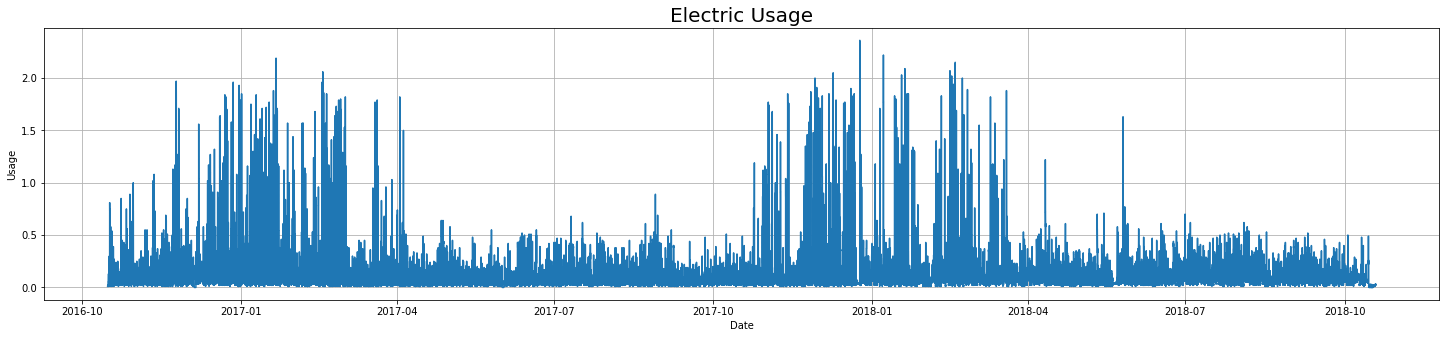

In [9]:
usage=df_new['USAGE'].values
date=df_new['DATE'].values

plt.figure(figsize=(25,5))
plt.plot(time_index, usage)
plt.title('Electric Usage',
          fontsize=20);
plt.xlabel('Date')
plt.ylabel('Usage')
plt.grid(True)

In [10]:
n = len(df_new)
n_train = n-int(n*0.2)
n_test = n-n_train
print("Banyaknya data ada ", n)
print("Banyaknya data training ada ", n_train)
print("Banyaknya data test ada ", n_test)

Banyaknya data ada  70368
Banyaknya data training ada  56295
Banyaknya data test ada  14073


In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_set = windowed_dataset(usage[:n_train], window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(usage[n_test:], window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [24]:
min_val_loss=0.002

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < min_val_loss):
      print("\nVal Loss less than 0.2%, training stopped.")
      self.model.stop_training = True

stopperTrain = myCallback()

In [25]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(delta=0.1, 
                                         reduction=tf.keras.losses.Reduction.NONE, 
                                         name='huber_loss'),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    validation_data=test_set,
                    epochs=20,
                    verbose=1,
                    callbacks=[stopperTrain])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
563/563 [==============================] - 83s 141ms/step - loss: 0.0040 - mae: 0.0621 - val_loss: 0.0028 - val_mae: 0.0482
Epoch 2/20
563/563 [==============================] - 79s 139ms/step - loss: 0.0038 - mae: 0.0602 - val_loss: 0.0027 - val_mae: 0.0480
Epoch 3/20
563/563 [==============================] - 79s 140ms/step - loss: 0.0037 - mae: 0.0584 - val_loss: 0.0026 - val_mae: 0.0450
Epoch 4/20
563/563 [==============================] - 79s 140ms/step - loss: 0.0036 - mae: 0.0566 - val_loss: 0.0026 - val_mae: 0.0439
Epoch 5/20
563/563 [==============================] - 79s 139ms/step - loss: 0.0035 - mae: 0.0551 - val_loss: 0.0025 - val_mae: 0.0426
Epoch 6/20
563/563 [==============================] - 79s 140ms/step - loss: 0.0034 - mae: 0.0535 - val_loss: 0.0024 - val_mae: 0.0418
Epoch 7/20
563/563 [==============================] - 79s 140ms/step - loss: 0.0033 - mae: 0.0522 - val_loss: 0.0024 - val_mae: 0.0407
Epoch 8/20
563/563 [==============================] - 7

In [79]:
import matplotlib.pyplot as plt

In [80]:
def graphic(x,y,a,b):
  plt.plot(history.history[x])
  plt.plot(history.history[y])
  plt.title('Model '+a)
  plt.ylabel(a)
  plt.xlabel('Epoch')
  plt.legend([a,b], loc='upper right')
  plt.show()

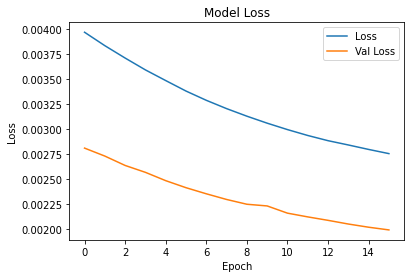

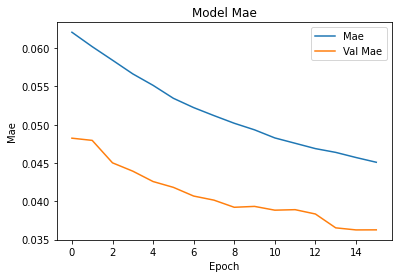

In [81]:
graphic('loss', 'val_loss', 'Loss', 'Val Loss')
graphic('mae', 'val_mae', 'Mae', 'Val Mae')

In [88]:
def model_electric(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w:w.batch(window_size))
  ds = ds.batch(128).prefetch(1)
  return model.predict(ds)

In [90]:
electric = np.array(model_electric(model, usage[..., np.newaxis], 60))
electric_test = electric[n_train-60:-1, 0]

print(electric)
print(electric_test)

[[0.069746  ]
 [0.05792309]
 [0.04877159]
 ...
 [0.03717721]
 [0.03883317]
 [0.039618  ]]
[0.06941672 0.06817248 0.06904242 ... 0.0345847  0.03717721 0.03883317]


In [91]:
print(tf.keras.metrics.mean_absolute_error(usage[n_train:], electric_test).numpy())
print(tf.keras.metrics.mean_squared_error(usage[n_train:], electric_test).numpy())

print(len(electric))
print(len(electric_test))

0.027301827
0.0036377928
70309
14073


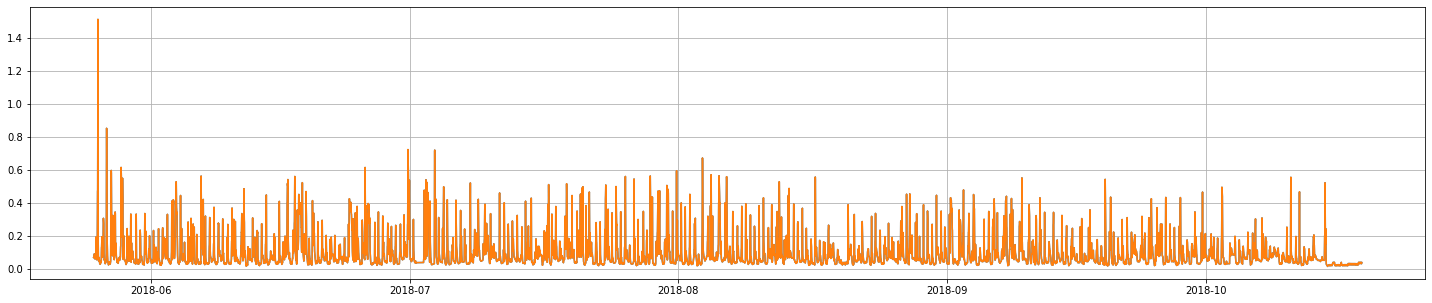

In [92]:
date=df_new.index.values
plt.figure(figsize=(25, 5))
plt.grid(True)
plt.plot(date[n_train:], electric_test)
plt.plot(date[n_train:], electric_test)
plt.show()